In [19]:
import torch
import torchvision
from torchvision import models

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Test if ResNet18 works now
try:
    model = models.resnet18(pretrained=False)
    print("✅ ResNet18 loaded successfully!")
except Exception as e:
    print(f"❌ Error: {e}")

PyTorch version: 2.7.1
CUDA available: False
✅ ResNet18 loaded successfully!


In [20]:
import numpy as np 
from pathlib import Path
#the line below accesses the file path of the images. Since the main.py file and the archive folder is under the malaria folder, 
#i dont have to write malaria as a part of the file pat
path = Path("archive/cell_images") 
#path.glob gets all the files and folders matching the identifier specified in the argument. it works for with file names,
#and extensions. '*/*.png' includes all subfolders and to not include subfolders its '*.png'
data = list(path.glob('*/*.png'))
uninfected = list(path.glob("Uninfected/*"))
print(len(uninfected))
print(len(data))
print(path.exists())

13780
27558
True


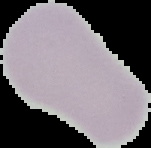

In [21]:
#just wanted to open the images
from PIL import Image
import PIL
PIL.Image.open(uninfected[1])

In [22]:
#resizing images to standardize the data because it leads to more consistentcy from the model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#defines transformer and resizes images 
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #data augmentation transforms for training
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), #rotate ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #±20% brightness, contrast, color saturation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)), #shift 10% in x, y between scale of 95-105

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([ #validation transform
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#loads dataset
dataset = datasets.ImageFolder(root='archive/cell_images', transform=transform)

#split the data into training, validating, and test. validating is used so we can see how the model looks while its training on it itself
#test is used so we can just test the model without seeing whats going on 
train_size = int(0.8 * len(dataset)) #training data is 80% of the dataset
val_size = len(dataset) - train_size #validating data is 20% of the dataset

# indices = torch.randperm(len(dataset)).tolist()
# train_indices = indices[:train_size]
# val_indices = indices[train_size:]

#randomly splits the data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [23]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
import torch.nn as nn
from torchvision import models
import torch.nn.functional as func

# class NeuralNet(nn.Module):
#     def __init__ (self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 12, 5) #kernel that scans through the image and creates 12 feature maps
#         self.bn1 = nn.BatchNorm2d(12)
#         self.conv2 = nn.Conv2d(12, 24, 5)
#         self.bn2 = nn.BatchNorm2d(24)
#         self.pool = nn.MaxPool2d(2, 2) #creates a 2x2 area that extracts 4 pixels of information and turns it into 1

#         self.dropout1 = nn.Dropout(0.25)
#         self.fc1 = nn.Linear(24 * 29 * 29, 128)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.pool(func.relu(self.bn1(self.conv1(x))))
#         x = self.pool(func.relu(self.bn2(self.conv2(x))))
#         x = self.dropout1(x)

#         x = torch.flatten(x,1)
#         x = func.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x

class TransferResNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.base_model = models.resnet18(pretrained=pretrained)

        for param in list(self.base_model.parameters())[:-10]:
            param.requires_grad = True #freeze base layers initially, unfreeze later layers
            #unfreeze all layers for fine tuning

        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [25]:
import torch.optim as optim 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = NeuralNet().to(device)
model = TransferResNet().to(device)

model.load_state_dict(torch.load('best_malaria_model.pth'))
print("Loaded saved model weights!")

#optimizer with different learning rate and weight decay
optimizer = optim.AdamW([
    {'params': model.base_model.fc.parameters(), 'lr': 0.0001},  #higher LR for new classifier layers
    {'params': [p for n, p in model.base_model.named_parameters() if 'fc' not in n], 'lr': 0.00001}  #lower LR for ResNet backbone
], weight_decay=0.01) 

#scheduler reduces learning rate when validation accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss()


Loaded saved model weights!


In [26]:
num_epochs = 5

train_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 96.77 #previous best

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards + optimization:
        optimizer.zero_grad()
        loss.backward()
        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        max_values, predicted_classes = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

        running_loss += loss.item()
        epoch_loss += loss.item()

        #only print for every 50 patches to make the file not like 50,000 lines
        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")

    #epoch averages
    train_acc = 100 * correct / total
    avg_loss = epoch_loss / len(train_loader)
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Summary: Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%")

    #validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            max_values, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    #update learning rate
    scheduler.step(val_acc)

    #save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_malaria_model.pth')
        print(f"New best model saved. Validation accuracy: {val_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)


Epoch [1/5], Batch [0/689], Loss: 0.0560, Accuracy: 96.88%
Epoch [1/5], Batch [50/689], Loss: 0.2131, Accuracy: 97.43%
Epoch [1/5], Batch [100/689], Loss: 0.0038, Accuracy: 97.68%
Epoch [1/5], Batch [150/689], Loss: 0.0878, Accuracy: 97.41%
Epoch [1/5], Batch [200/689], Loss: 0.0048, Accuracy: 97.31%
Epoch [1/5], Batch [250/689], Loss: 0.0097, Accuracy: 97.36%
Epoch [1/5], Batch [300/689], Loss: 0.1609, Accuracy: 97.32%
Epoch [1/5], Batch [350/689], Loss: 0.0101, Accuracy: 97.36%
Epoch [1/5], Batch [400/689], Loss: 0.0292, Accuracy: 97.36%
Epoch [1/5], Batch [450/689], Loss: 0.0719, Accuracy: 97.32%
Epoch [1/5], Batch [500/689], Loss: 0.1245, Accuracy: 97.36%
Epoch [1/5], Batch [550/689], Loss: 0.0044, Accuracy: 97.39%
Epoch [1/5], Batch [600/689], Loss: 0.1591, Accuracy: 97.42%
Epoch [1/5], Batch [650/689], Loss: 0.0145, Accuracy: 97.36%
Epoch [1/5] Training Summary: Loss: 0.0863, Accuracy: 97.39%
New best model saved. Validation accuracy: 98.04%
Validation Accuracy: 98.04%
----------

In [27]:
model.load_state_dict(torch.load('best_malaria_model.pth'))
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    
# print(f"Test Accuracy: {100* test_correct / test_total:.2f}%")
final_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Final Test Accuracy: 97.99%
Best Validation Accuracy: 98.11%
